#### 필요한 Module Import 및 변수 설정

In [1]:
''' 1. Module Import '''
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# Batch_Size, Train_epoch 설정
BATCH_SIZE = 128
TRN_EPOCHS = 10

#### device 설정

In [3]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0+cpu  Device: cpu


#### 데이터셋 다운로드 및 확인

In [4]:
''' 3. CIFAR10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor()) # 이미지를 Tensor 형태로 변환(0~1)

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10\cifar-10-python.tar.gz to ../data/CIFAR_10


------
##### Data Augmentation 기법
- `transforms.RandomHorizontalFlip()` : 해당 이미지를 50%의 확률로 좌우 반전
- `transforms.Normalize((R 평균, G 평균, B 평균), (R 표준편차, G 표준편차, B 표준편차))` : 각 채널별 이미지 픽셀 값을 채널별 평균을 뺀 뒤 표준편차로 나누어 계산
    - 최소값 : (0 - 0.5) / 0.5 = -1
    - 최대값 : (1 - 0.5) / 0.5 = 1

In [5]:
'''
# 데이터 다운로드 시 Data Augmentation 기법 적용하기
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)
'''

'\n# 데이터 다운로드 시 Data Augmentation 기법 적용하기\ntrain_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",\n                                 train = True,\n                                 download = True,\n                                 transform = transforms.Compose([transforms.RandomHorizontalFlip(),\n                                                                 transforms.ToTensor(),\n                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))\n\ntest_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",\n                                train = False,\n                                transform = transforms.Compose([transforms.RandomHorizontalFlip(),\n                                                                transforms.ToTensor(),\n                                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))\n\ntrain_loader = torch.utils.data.DataLoader(dataset = train_d

------

In [6]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor


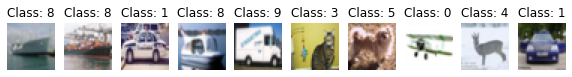

In [7]:
''' 5. 데이터 확인하기 (2) '''
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

#### 모델 설계
## CNN 모델 Class (1)

In [8]:
''' 6. Convolutional Neural Network(CNN) 모델 설계하기 (1) '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(8 * 8 * 16, 64) # 값_채우기 정답 : 8 * 8 * 16 = 1024
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

        
    def forward(self, x):
        x = self.conv1(x) # (batch_size, 3, 32, 32) -> (batch_size, 8, 32, 32)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 8, 32, 32) -> (batch_size, 8, 16, 16)
        x = self.conv2(x) # (batch_size, 8, 16, 16) -> (batch_size, 16, 16, 16)
        x = F.relu(x)
        x = self.pool(x)  # (batch_size, 16, 16, 16) -> (batch_size, 16, 8, 8)

        x = x.view(-1, 8 * 8 * 16) # 값_채우기 정답 : 8 * 8 * 16 = 1024
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        out = F.log_softmax(x)
        return out

## CNN 모델 Class (2)

In [9]:
''' 7. Convolutional Neural Network(CNN) 모델 설계하기 (2) '''
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.feature_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(#값_채우기, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        
    def forward(self, x):
        x = self.feature_layer(x)

        x = x.view(-1, #값_채우기)
        
        x = self.fc_layer(x)
        out = F.log_softmax(x)
        return out

In [10]:
# 생성한 모델 확인
model = CNN().to(DEVICE)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


#### Optimizer, Objective Function 설정

In [11]:
''' 8. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

#### 모델 학습 및 학습 데이터의 성능 확인하는 `train` 함수 정의

In [12]:
''' 9. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()                       # 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()           # Optimizer의 Gradient를 0으로 초기화
        output = model(image)
        loss = criterion(output, label) # CrossEntropy를 이용해 Loss값 계산
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def forward(self, x):
    x = self.conv1(x) # (batch_size, 3, 32, 32) -> (batch_size, 8, 32, 32)
    x = F.relu(x)
    x = self.pool(x)  # (batch_size, 8, 32, 32) -> (batch_size, 8, 16, 16)
    x = self.conv2(x) # (batch_size, 8, 16, 16) -> (batch_size, 16, 16, 16)
    x = F.relu(x)
    x = self.pool(x)  # (batch_size, 16, 16, 16) -> (batch_size, 16, 8, 8)
    
    x = x.view(-1, 8 * 8 * 16) # 값_채우기 정답 : 8 * 8 * 16 = 1024

In [15]:
''' 1. Convolution Layer 설정 '''
# nn.Conv2d(입력채널수, 출력채널수, 커널(필터)사이즈, 등등)
conv = nn.Conv2d(3, 8, 3, padding = 1) 
print(conv)

''' 2. Input Size 설정 및 출력 '''
# 입력값의 Size와 동일한 텐서 설정 : torch.Tensor(batch_size, 채널, W, H)
conv_inputs = torch.Tensor(1, 3, 32, 32)
print(f' Input shape : {conv_inputs.shape}')

''' 3. Output Size 출력 '''
conv_out = conv(conv_inputs)
print(f'Output shape : {conv_out.shape}')

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 Input shape : torch.Size([1, 3, 32, 32])
Output shape : torch.Size([1, 8, 32, 32])


> Pooling의 output 크기에 대한 실습 코드입니다. 입력된 값은 pool의 설정 값들을 사용한 것으로 size를 계산할 때 활용해보세요.


In [16]:
''' 1. Pooling Layer 설정 '''
# nn.MaxPool2d(커널(필터)사이즈, 스트라이드, 등등)
pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
print(pool2)

''' 2. Input Size 설정 및 출력 '''
# 입력값의 Size와 동일한 텐서 설정: torch.Tensor(batch_size, 채널, W, H)
pool2_inputs = torch.Tensor(1, 3, 32, 32)
print(f' Input shape : {pool2_inputs.shape}')

''' 3. Output Size 출력 '''
pool2_out = pool2(pool2_inputs)
print(f'Output shape : {pool2_out.shape}')

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Input shape : torch.Size([1, 3, 32, 32])
Output shape : torch.Size([1, 3, 16, 16])


## ResNet


<p align = "left">
  <img width = "600" src = "https://github.com/skdytpq/skdytpq.github.io/blob/master/_pics/RE%2CDE/resnet6.png?raw=true">
  <br>
          ResNet 구조
</p>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면?
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes) # kervel_size 를 1로 진행하여 차원을 맞춘 것
            ) # stride 가 1이 아니라면, 즉 다시말해 input data channel 의 차원이 달라지게 된다면, x 의 차원을 맞춘다.

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) 
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # feature size 가 작아지는 풀링
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 두번 반복하겠다는 의미
        # 첫 Stride 는 Feature map 의 size 를 감소시키겠다는 의미이고 하나의 Block 내부에서는 Feature map 감소가 없기 때문에 Stride = 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers) # Basic block 을 몇번 반복할 것인지.

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # 출력: [batch_size, 512, 4, 4]
        out = F.avg_pool2d(out, 4) # 출력: [batch_size, 512, 1, 1]
        out = out.view(out.size(0), -1) # 출력: [batch_size, 512]
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)

learning_rate = 0.1
file_name = 'resnet18_cifar10.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader): # len / 128 몫 batch_idx -1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets) # output 이 softmax 를 거친 후 cross entropy 를 계산한다.
        loss.backward() # 가중치 기울기 구하는 것

        optimizer.step() # update
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        current_correct = predicted.eq(targets).sum().item()
        correct += current_correct
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / targets.size(0))
            print('Current batch average train loss:', loss.item() / targets.size(0))

    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTotal average test accuarcy:', correct / total)
    print('Total average test loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

In [ ]:
import time


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

start_time = time.time()

for epoch in range(0, 150):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)
    print('\nTime elapsed:', time.time() - start_time)